# Importing and Loading the data

In [2]:
# Import & load
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv(r"C:\Users\DELL\OneDrive\Desktop\training\sentiment analysis amazon\data\amazon_alexa.csv")


# Expolatery Data Analysis

In [3]:
print("Dataset shape : ", df.shape)
print(df.info())
print(df.head())

Dataset shape :  (3150, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0    rating           3150 non-null   int64 
 1   date              3150 non-null   object
 2   variation         3150 non-null   object
 3   verified_reviews  3149 non-null   object
 4   feedback          3150 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 123.2+ KB
None
    rating       date         variation  \
0        5  31-Jul-18  Charcoal Fabric    
1        5  31-Jul-18  Charcoal Fabric    
2        4  31-Jul-18    Walnut Finish    
3        5  31-Jul-18  Charcoal Fabric    
4        5  31-Jul-18  Charcoal Fabric    

                                    verified_reviews  feedback  
0                                      Love my Echo!         1  
1                                          Loved it!         1  
2  Sometimes while playing a game,

In [4]:
# Remove spaces from column names
df.columns = df.columns.str.replace(" ", "")

In [5]:
# Missing Values
print("Missing values per column : ")
print(df.isnull().sum())

Missing values per column : 
rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64


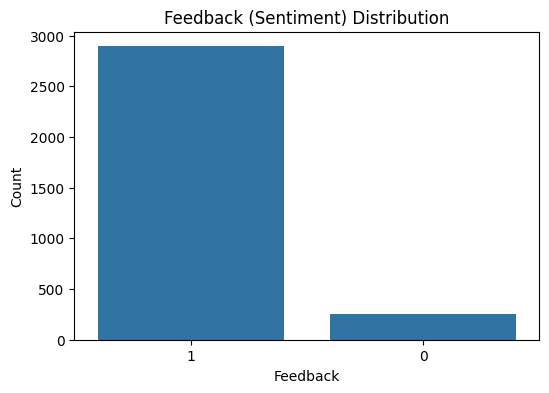

In [6]:
# Distribution of feedback
plt.figure(figsize = (6,4))
sns.countplot(data = df, x = 'feedback', order = df['feedback'].value_counts().index)
plt.title('Feedback (Sentiment) Distribution')
plt.xlabel('Feedback')
plt.ylabel('Count')
plt.show()

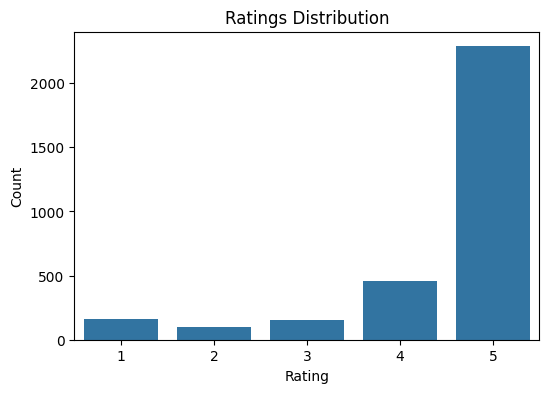

In [7]:
# Distribution of rating
plt.figure(figsize = (6,4))
sns.countplot(data = df, x = 'rating', order = sorted(df['rating'].unique()))
plt.title('Ratings Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

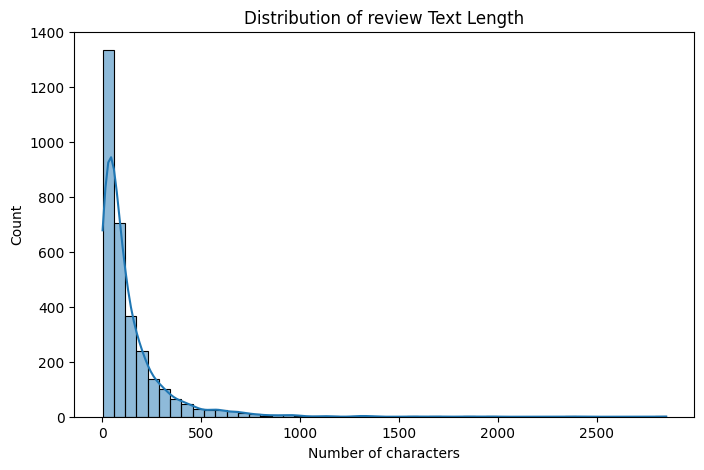

In [8]:
# Review length feature
df['review_length'] = df['verified_reviews'].astype(str).apply(len)
plt.figure(figsize = (8,5))
sns.histplot(df['review_length'], bins = 50, kde = True)
plt.title('Distribution of review Text Length')
plt.xlabel('Number of characters')
plt.ylabel('Count')
plt.show()

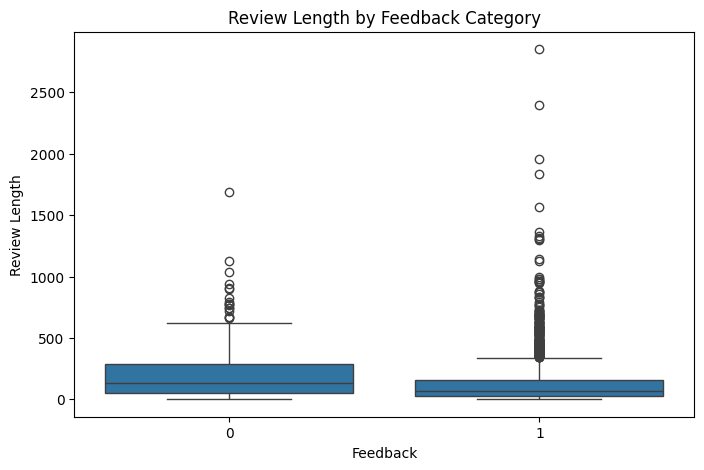

In [9]:
# Boxplot review length vs feedback
plt.figure(figsize = (8,5))
sns.boxplot(x = 'feedback', y = 'review_length', data = df)
plt.title('Review Length by Feedback Category')
plt.xlabel('Feedback')
plt.ylabel('Review Length')
plt.show()

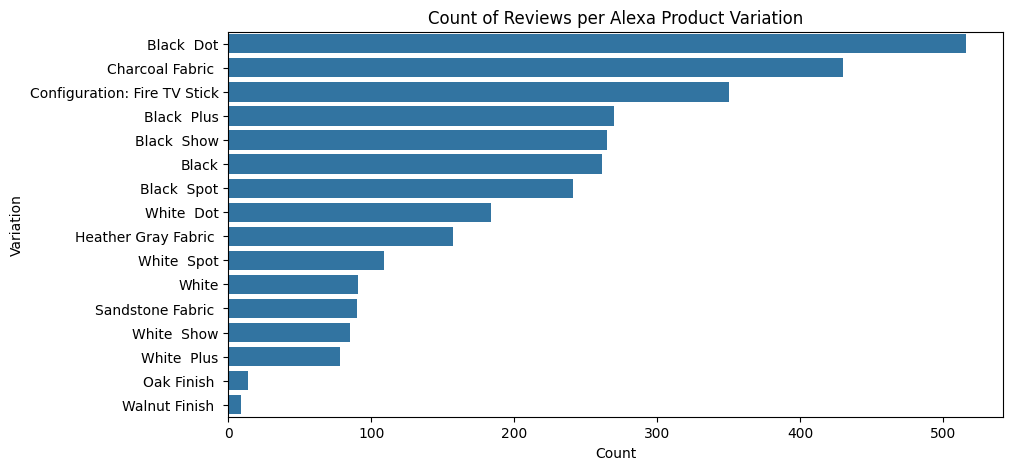

In [10]:
# Reviewa count per product variation
plt.figure(figsize = (10,5))
sns.countplot(y = 'variation', data = df, order = df['variation'].value_counts().index)
plt.title('Count of Reviews per Alexa Product Variation')
plt.xlabel('Count')
plt.ylabel('Variation')
plt.show()

C:\Users\DELL\AppData\Local\Temp\ipykernel_16568\2693810486.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'], errors='coerce')


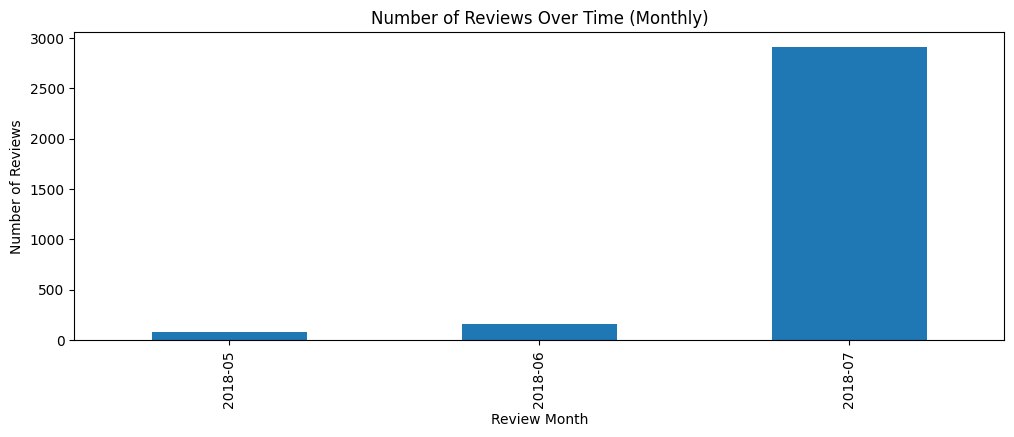

In [11]:
# Review date distribution
df['date'] = pd.to_datetime(df['date'], errors='coerce')
plt.figure(figsize = (12,4))
df['date'].dt.to_period('M').value_counts().sort_index().plot(kind = 'bar')
plt.title('Number of Reviews Over Time (Monthly)')
plt.xlabel('Review Month')
plt.ylabel('Number of Reviews')
plt.show()

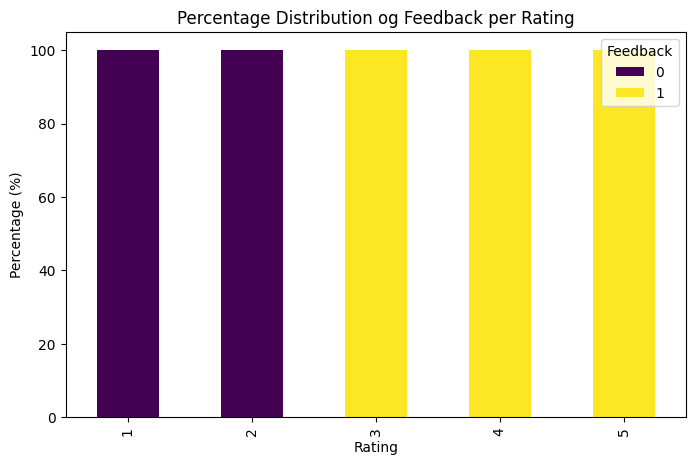

In [12]:
# Correlation between rating and feedback
rating_feedback = pd.crosstab(df['rating'], df['feedback'], normalize='index') * 100
rating_feedback.plot(kind = 'bar', stacked = True, figsize = (8, 5), colormap = 'viridis')
plt.title('Percentage Distribution og Feedback per Rating')
plt.xlabel('Rating')
plt.ylabel('Percentage (%)')
plt.legend(title = 'Feedback')
plt.show()

# Preprocessing (cleaning, tokenization, stopwords, lemmatization)

In [13]:
import re
import  nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [14]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
  if pd.isna(text):
    return ''
  text = str(text).lower()
  text = re.sub(r'[^a-z\s]', ' ', text)
  tokens = word_tokenize(text)
  tokens = [t for t in tokens if t not in stop_words and len(t) > 1]
  lem = [lemmatizer.lemmatize(t) for t in tokens]
  return ' '.join(lem)

df['clean_text'] = df['verified_reviews'].astype(str).apply(clean_text)
df['clean_text'].head()

0                                            love echo
1                                                loved
2    sometimes playing game answer question correct...
3    lot fun thing yr old learns dinosaur control l...
4                                                music
Name: clean_text, dtype: object

# TF-IDF vectorization

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features = 4000, ngram_range = (1,2))
X_tfidf = tfidf.fit_transform(df['clean_text'])
y = df['feedback'].values
X_tfidf.shape

(3150, 4000)

# Train / Test Split

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size = 0.2, random_state = 42, stratify = y
)

# Classical models (Naive Bayes + Logistic Regression )

In [17]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, log_loss
import joblib

# Naive Bayes
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)
y_pred_nb_proba = nb.predict_proba(X_test)[:,1]
print("Naive Bayes : \n", classification_report(y_test, y_pred_nb))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_nb_proba))
print("Log Loss:", log_loss(y_test, y_pred_nb_proba))

# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
y_pred_lr_proba = lr.predict_proba(X_test)[:,1]
print("Logistic Regression : \n", classification_report(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_lr_proba))
print("Log Loss:", log_loss(y_test, y_pred_lr_proba))

# Save artifacts
joblib.dump(nb, "nb_model.joblib")
joblib.dump(lr, "lr_model.joblib")
joblib.dump(tfidf, "tfidf_model.joblib")
print("Saved NB, LR, TF-DIF")

Naive Bayes : 
               precision    recall  f1-score   support

           0       1.00      0.02      0.04        51
           1       0.92      1.00      0.96       579

    accuracy                           0.92       630
   macro avg       0.96      0.51      0.50       630
weighted avg       0.93      0.92      0.88       630

ROC-AUC: 0.8798638626435029
Log Loss: 0.23851233522834828
Logistic Regression : 
               precision    recall  f1-score   support

           0       0.67      0.04      0.07        51
           1       0.92      1.00      0.96       579

    accuracy                           0.92       630
   macro avg       0.79      0.52      0.52       630
weighted avg       0.90      0.92      0.89       630

ROC-AUC: 0.934894510481222
Log Loss: 0.21204717411339083
Saved NB, LR, TF-DIF


# Visualization : confusion matrices, ROC, wordclouds, distribution

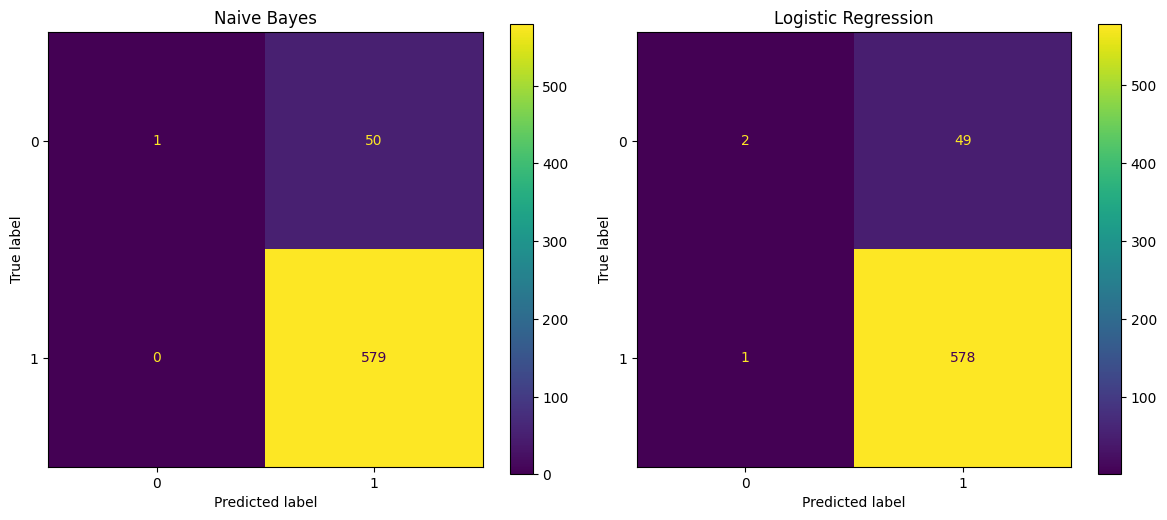

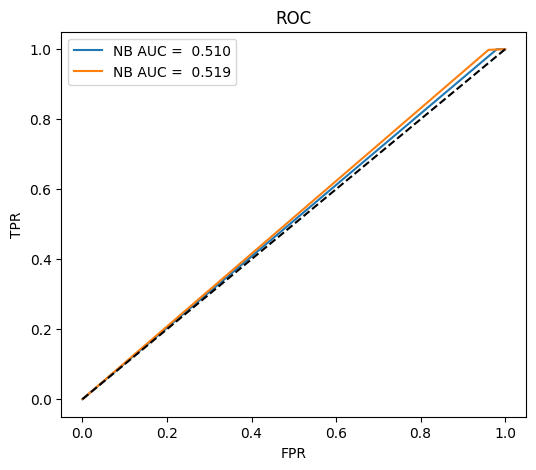

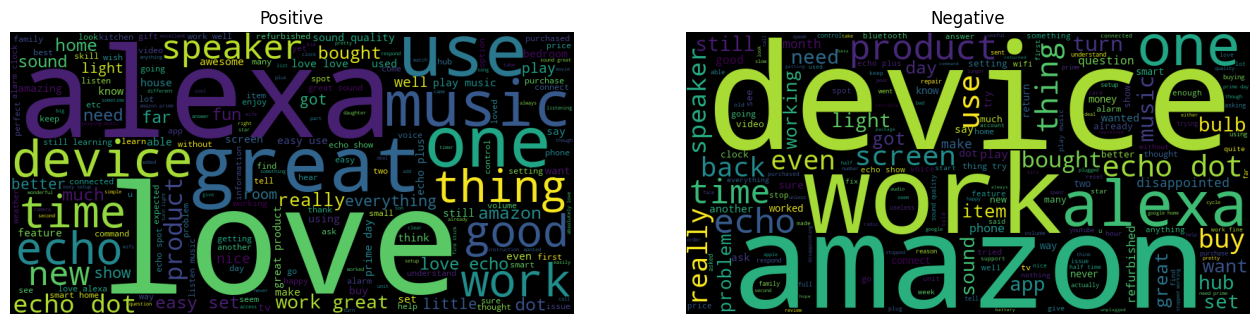

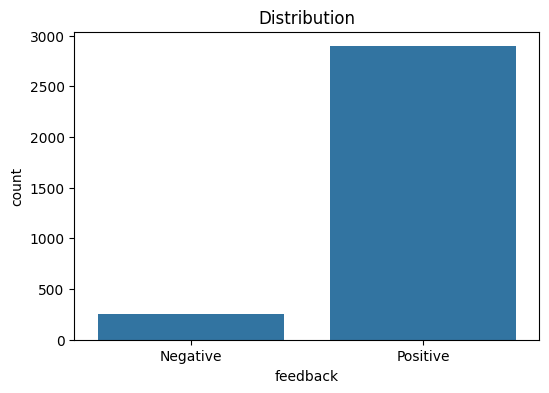

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay
from wordcloud import WordCloud

# confusion metrices
fig, axes = plt.subplots(1,2, figsize = (12, 5))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_nb)).plot(ax = axes[0])
axes[0].set_title('Naive Bayes')
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_lr)).plot(ax = axes[1])
axes[1].set_title('Logistic Regression')
plt.tight_layout()
plt.savefig('confusion_matrices.png')
plt.show()

#ROC
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_pred_nb)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr)
plt.figure(figsize = (6,5))
plt.plot(fpr_nb, tpr_nb, label = f'NB AUC = {roc_auc_score(y_test, y_pred_nb) : .3f}')
plt.plot(fpr_lr, tpr_lr, label = f'NB AUC = {roc_auc_score(y_test, y_pred_lr) : .3f}')
plt.plot([0,1], [0,1], 'k--')
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.savefig('roc_curves.png')
plt.show()

# WordClouds
pos_text = ' '.join(df[df['feedback'] == 1]['clean_text'].tolist())
neg_text = ' '.join(df[df['feedback'] == 0]['clean_text'].tolist())
wc_pos = WordCloud(width = 800, height = 400).generate(pos_text)
wc_neg = WordCloud(width = 800, height = 400).generate(neg_text)
plt.figure(figsize = (16,6))
plt.subplot(1,2,1)
plt.imshow(wc_pos)
plt.axis('off')
plt.title('Positive')
plt.subplot(1,2,2)
plt.imshow(wc_neg)
plt.axis('off')
plt.title('Negative')
plt.savefig('wordclouds.png')
plt.show()

# Sentiment Distribution
plt.figure(figsize =(6,4))
sns.countplot(x = 'feedback', data = df)
plt.xticks([0,1], ['Negative','Positive'])
plt.title('Distribution')
plt.savefig('sentiment_dist.png')
plt.show()

# LSTM pipeline (tokenize, pad, model)

In [18]:
# !pip install tensorflow

In [19]:
# import tensorflow as tf
# print(tf.__version__)

In [19]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout

ImportError: Traceback (most recent call last):
  File "C:\Users\DELL\AppData\Roaming\Python\Python312\site-packages\tensorflow\python\pywrap_tensorflow.py", line 73, in <module>
    from tensorflow.python._pywrap_tensorflow_internal import *
ImportError: DLL load failed while importing _pywrap_tensorflow_internal: A dynamic link library (DLL) initialization routine failed.


Failed to load the native TensorFlow runtime.
See https://www.tensorflow.org/install/errors for some common causes and solutions.
If you need help, create an issue at https://github.com/tensorflow/tensorflow/issues and include the entire stack trace above this error message.

In [ ]:
tokenizer = Tokenizer(num_words = 8000, oov_token = '<OOV>')
tokenizer.fit_on_texts(df['clean_text'])
sequences = tokenizer.texts_to_sequences(df['clean_text'])
padded = pad_sequences(sequences, maxlen = 100, padding = 'post', truncating = 'post')

from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(padded, y, test_size = 0.2, random_state= 42, stratify = y)

model = Sequential([
    Embedding(input_dim=8000, output_dim=64, input_length=100),
    Bidirectional(LSTM(32)),
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Train (use more epochs for final run)
history = model.fit(X_tr, y_tr, epochs=6, batch_size=64, validation_data=(X_te, y_te))

loss, acc = model.evaluate(X_te, y_te)
print("LSTM test acc:", acc)

# Save
model.save('lstm_model.keras')
import pickle
with open('tokenizer.pkl','wb') as f:
    pickle.dump(tokenizer, f)

# Dashboard helper (predict function)

In [ ]:
import joblib, pickle
nb = joblib.load('nb_model.joblib')
lr = joblib.load('lr_model.joblib')
tfidf = joblib.load('tfidf_model.joblib')
with open('tokenizer.pkl','rb') as f:
  tokenizer = pickle.load(f)

def predict_text(text):
  clean = clean_text(text)
  X = tfidf.transform([clean])
  p_nb = nb.predict_proba(X)[:,1][0]
  p_lr = lr.predict_proba(X)[:,1][0]
  avg = (p_nb + p_lr)/2
  label = 'Positive' if avg > 0.5 else 'Negative'
  return { 'label' : label, 'probability' : float(avg), 'nb_prob' : float(p_nb), 'lr_prob' : float(p_lr)}